In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression

In [13]:
cs = pd.read_csv(r"C:\Users\ifixthat\Downloads\Compressed\PYTHON\PYTHON Insurance case study\Case Study 3 - Insurance Claims Case Study\cust_demographics.csv")
cs.head(2)


,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver


In [14]:
cld = pd.read_csv(r"C:\Users\ifixthat\Downloads\Compressed\PYTHON\PYTHON Insurance case study\Case Study 3 - Insurance Claims Case Study\claims.csv")
cld.head(2)


,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1.0,No
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3.0,No


In [15]:
cld_cs = cs.merge(cld , how = 'inner' , right_on ='customer_id' , left_on = 'CUST_ID')
cld_cs.drop(columns = 'customer_id' , inplace = True)

### ***2. Perform a data audit for the datatypes and find out if there are any mismatch within the current datatypes of the columns and their  business significance.***

In [16]:
cld_cs[['CUST_ID','claim_id']] = cld_cs[['CUST_ID','claim_id']].astype(object)

In [17]:
cld_cs[['DateOfBirth', 'claim_date']] = cld_cs[['DateOfBirth', 'claim_date']].apply(lambda x : pd.to_datetime(x) ) 

### ***3. Convert the column claim_amount to numeric. Use the appropriate                                                  modules/attributes to remove the $ sign.***

In [18]:
cld_cs.claim_amount = cld_cs.claim_amount.str.replace('$',' ', )

C:\Users\ifixthat\AppData\Local\Temp\ipykernel_11372\869477614.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cld_cs.claim_amount = cld_cs.claim_amount.str.replace('$',' ', )


In [19]:
cld_cs.claim_amount = cld_cs.claim_amount.astype('float64')

### ***4. Of all the injury claims, some of them have gone unreported with the                                                              police. Create an alert flag (1,0) for all such claims.***

In [25]:
cld_cs['alert_flag'] = np.where(cld_cs.police_report=='Yes' , '1' , '0')

In [26]:
cld_cs['alert_flag'] = np.where(cld_cs.police_report == 'Unknown' , '1,0', cld_cs.alert_flag )

### 5. One customer can claim for insurance more than once and in each claim,                                                      multiple categories of claims can be involved. However, customer ID                                                                               should remain unique. Retain the most recent observation and delete any duplicated records in                                  the data based on the customer ID column.

In [27]:
cld_cs = cld_cs.sort_values(['claim_date','CUST_ID'] , ascending = False)
cld_cs.drop_duplicates(subset = ['CUST_ID'] , keep = ('first') , inplace = True)

### ***6. Check for missing values and impute the missing values with an                                                              appropriate value. (mean for continuous and mode for categorical)***

In [29]:
cld_cs.claim_amount.fillna(cld_cs.claim_amount.mean() , inplace = True)

In [30]:
cld_cs.total_policy_claims.fillna(cld_cs.total_policy_claims.mean() , inplace = True)

### 7. Calculate the age of customers in years. Based on the age, categorize the                                                  customers according to the below criteria                                                                                                                           Children < 18                                                                                                                                                                               Youth 18-30                                                                                                                                                                                  Adult 30-60                                                                                                                                                                                  Senior > 60

In [31]:
cld_cs['DateOfBirth'] = np.where(pd.DatetimeIndex (cld_cs['DateOfBirth']).year<2000 , cld_cs.DateOfBirth , cld_cs.DateOfBirth + pd.DateOffset(years= -100))

In [35]:
today = pd.Timestamp.now()
today.year

2023

In [36]:
cld_cs['age'] = ( cld_cs.DateOfBirth.apply(lambda x : today.year - x.year))


In [37]:
cld_cs['age_group'] = pd.cut(cld_cs['age'], bins=[0, 18, 30, 60, 100], labels=['Children', 'Youth', 'Adult', 'Senior'])

### 8. What is the average amount claimed by the customers from various segments?

In [38]:
cld_cs.groupby('Segment')['claim_amount'].mean()

Segment
Gold        12846.400227
Platinum    12371.654843
Silver      12267.859374
Name: claim_amount, dtype: float64

### 9. What is the total claim amount based on incident cause for all the claims                           that have been done at least 20 days prior to 1st of October, 2018.

In [39]:
a = cld_cs.loc[cld_cs.claim_date < '09/10/2018', : : ]


In [42]:
a.groupby('incident_cause')['claim_amount'].sum().reset_index()

,incident_cause,claim_amount
0,Crime,7.219386e+05
1,Driver error,3.315851e+06
2,Natural causes,1.312987e+06
3,Other causes,3.723152e+06
4,Other driver error,3.277536e+06


### 10. How many adults from TX, DE and AK claimed insurance for driver                                                               related issues and causes? 

In [43]:
cld_cs.loc[(cld_cs.incident_cause == 'Driver error') & ((cld_cs.State == 'DE')| (cld_cs.State == "TX") | (cld_cs.State == "AK")) ,  : :  ].groupby('State')['CUST_ID'].count()

State
AK     6
DE    10
TX     6
Name: CUST_ID, dtype: int64

### 11. Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage on the pie chart.


In [57]:
pc = pd.DataFrame(cld_cs.groupby(['Segment','gender'])['claim_amount'].mean()).reset_index()
pc


,Segment,gender,claim_amount
0,Gold,Female,12339.441748
1,Gold,Male,13279.849726
2,Platinum,Female,12278.352777
3,Platinum,Male,12478.841145
4,Silver,Female,11641.380032
5,Silver,Male,12825.871029


In [52]:
pc1 = pc.pivot_table(index = 'gender' , columns = 'Segment' , values = 'claim_amount')
pc1


Segment,Gold,Platinum,Silver
gender,,,
Female,12339.441748,12278.352777,11641.380032
Male,13279.849726,12478.841145,12825.871029


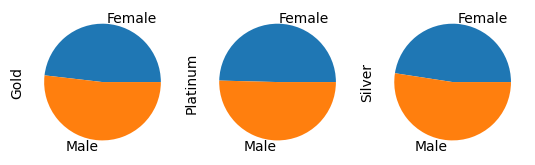

<Figure size 800x800 with 0 Axes>

In [60]:
pc1.plot(kind = 'pie' , subplots =True , legend = False)
plt.figure(figsize=(8,8))
plt.show()

### 12. Among males and females, which gender had claimed the most for any                                                                type of driver related issues? E.g. This metric can be compared using a                                                                           bar chart

In [48]:
bc = pd.DataFrame(cld_cs.loc[cld_cs.incident_cause.str.lower().str.contains('driver') , : : ].groupby('gender')['claim_amount'].sum()).reset_index()
bc

,gender,claim_amount
0,Female,3.136718e+06
1,Male,3.975412e+06


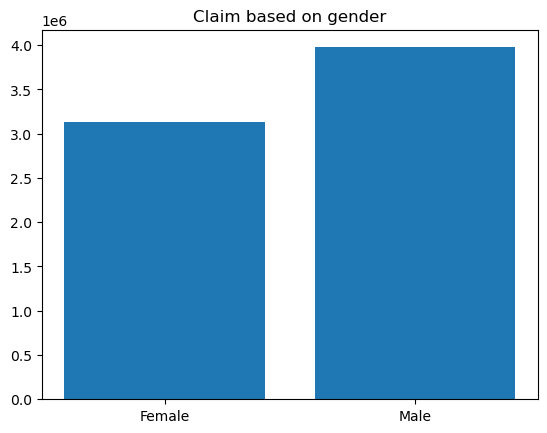

In [49]:
plt.bar(bc.gender,bc.claim_amount)
plt.title('Claim based on gender')
plt.show()


### 13. Which age group had the maximum fraudulent policy claims? Visualize                                                                it on a bar chart.


In [61]:
fc = pd.DataFrame(cld_cs.loc[cld_cs.fraudulent=='Yes' , : : ].groupby('age_group')['total_policy_claims'].count()).reset_index()
fc

,age_group,total_policy_claims
0,Children,0
1,Youth,39
2,Adult,185
3,Senior,21


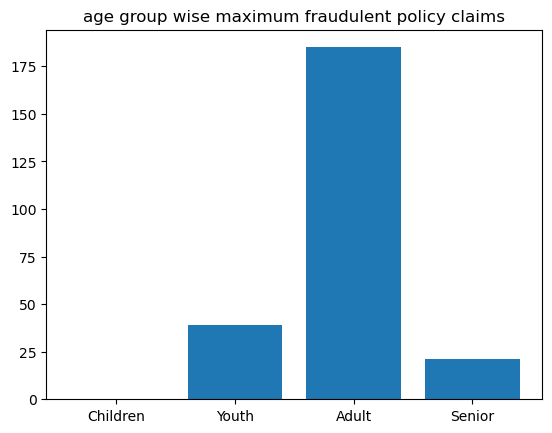

In [62]:
plt.bar(fc.age_group,fc.total_policy_claims)
plt.title('age group wise maximum fraudulent policy claims')
plt.show()

### 14. Visualize the monthly trend of the total amount that has been claimed                                                                  by the customers. Ensure that on the “month” axis, the month is in a                                                        chronological order not alphabetical order.

In [69]:
cld_cs['Month'] = cld_cs.claim_date.apply(lambda x : pd.Timestamp.strftime(x , format = '%b'))

In [70]:
lc = pd.DataFrame(cld_cs.groupby('Month')['claim_amount'].sum().reset_index().sort_values(by='claim_amount' ))
lc

,Month,claim_amount
9,Nov,6.011875e+05
2,Dec,6.942527e+05
1,Aug,9.112972e+05
11,Sep,9.832003e+05
8,May,1.114461e+06
3,Feb,1.164542e+06
6,Jun,1.279030e+06
0,Apr,1.292514e+06
7,Mar,1.320250e+06
4,Jan,1.327171e+06


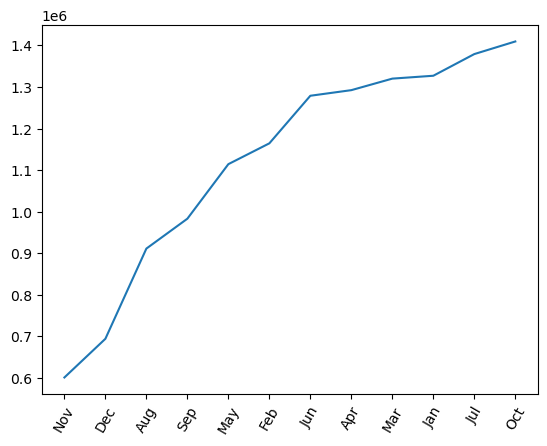

In [71]:
plt.plot(lc.Month , lc.claim_amount)
plt.xticks(rotation=60)
plt.show()

### 15. What is the average claim amount for gender and age categories and                                                                suitably represent the above using a facetted bar chart, one facet that                                                                      represents fraudulent claims and the other for non-fraudulent claims.

In [72]:
fraud_yes =pd.DataFrame(cld_cs.loc[cld_cs.fraudulent=='Yes' ,: : ].groupby(['gender','age_group'])['claim_amount'].mean()).reset_index()
fraud_yes

,gender,age_group,claim_amount
0,Female,Children,NaN
1,Female,Youth,9220.495534
2,Female,Adult,12630.113839
3,Female,Senior,3779.076923
4,Male,Children,NaN
5,Male,Youth,7799.623697
6,Male,Adult,16049.184674
7,Male,Senior,16879.125000


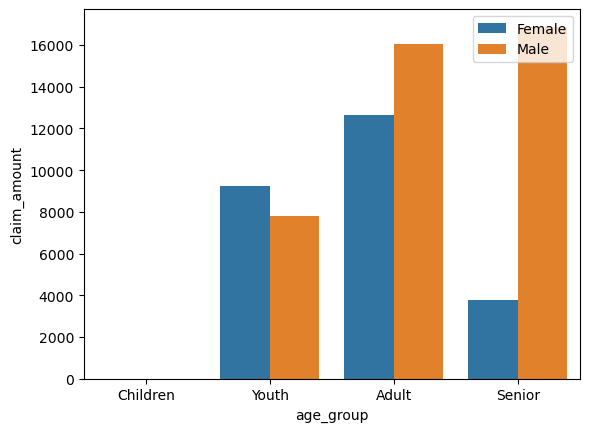

In [74]:
sns.barplot(fraud_yes , x = fraud_yes.age_group,y = fraud_yes.claim_amount , hue = 'gender')
plt.legend(loc = 'upper right')
plt.show()

In [75]:
fraud_no = pd.DataFrame(cld_cs.loc[cld_cs.fraudulent=='No', : : ].groupby(['gender','age_group'])['claim_amount'].mean()).reset_index()
fraud_no

,gender,age_group,claim_amount
0,Female,Children,NaN
1,Female,Youth,13174.551022
2,Female,Adult,11982.841119
3,Female,Senior,14965.431639
4,Male,Children,NaN
5,Male,Youth,12089.549538
6,Male,Adult,12375.035967
7,Male,Senior,12607.781770


<Axes: xlabel='age_group', ylabel='claim_amount'>

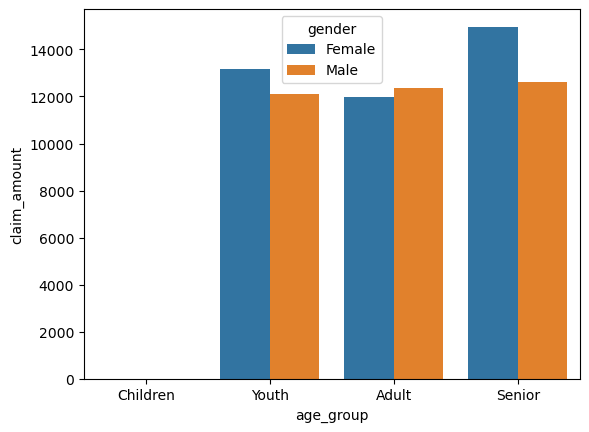

In [76]:
sns.barplot(fraud_no , x = fraud_no.age_group,y = fraud_no.claim_amount , hue = 'gender')

### 16. Is there any similarity in the amount claimed by males and females?

## 1. Null Hypothesis (H0) :

    u1 != u2
       or
      There is no similarity in the mean of amount claimed by males and females.

## 2. Alternate Hypothesis (Ha):
         u1 = u2
        There is similarity in the mean of amount claimed by males and females.

### 3. CI & p VALUES :
         CI = 95%
         p values = 0.05


## Perform the test : 
 #### F test


In [77]:
male = cld_cs.loc[cld_cs.gender == 'Male' , 'claim_amount']
male

286     42124.500000
1077     2290.000000
1055     2420.000000
941      1830.000000
751     12501.726555
            ...     
177      2080.000000
312     37290.000000
120      2967.000000
739      1840.000000
334     20310.000000
Name: claim_amount, Length: 551, dtype: float64

In [78]:
female = cld_cs.loc[cld_cs.gender == 'Female' , 'claim_amount' ]
female

697      1860.000000
322     12501.726555
238     26310.000000
354      1940.000000
226     17020.000000
            ...     
1064    20630.000000
195     17290.000000
181     30930.000000
905     27670.000000
383      2900.000000
Name: claim_amount, Length: 527, dtype: float64

In [79]:
stats.f_oneway(male,female)

F_onewayResult(statistic=0.9264242385640077, pvalue=0.3360100613538194)

### 5. Rejection Rule:
        The new p value is greater than original p value(0.05).
        Hence we do not reject the null hypothesis.

### 6.Bussiness conclusion:
       Pvalue is > 0.05. Hence we do not reject the  Null Hypothesis H0 and there is no relationship for the amount claimed by males and females.

### 17. Is there any relationship between age category and segment?

###  1.Null hypothesis (H0):
        There is no relationship between age category and category.

### 2.Alternate hypothesis  (HA) :
        There is relationship between age category and segment.

### 3.Confidence level & p value:
        CI = 95% 
        p value = 0.05

### Perform the test :
        Chi squared test

### Creating cross tab :

In [82]:
obs_frq = pd.crosstab(index = cld_cs.Segment , columns = cld_cs.age_group)
obs_frq

age_group,Youth,Adult,Senior
Segment,,,
Gold,71,272,28
Platinum,69,266,26
Silver,68,257,21


In [83]:
stats.chi2_contingency(obs_frq)

Chi2ContingencyResult(statistic=0.6654696397990999, pvalue=0.9555179463691874, dof=4, expected_freq=array([[ 71.58441558, 273.6038961 ,  25.81168831],
       [ 69.65491651, 266.22912801,  25.11595547],
       [ 66.7606679 , 255.16697588,  24.07235622]]))

### 5. Rejection Rule:
        The new p value is greater than original p value(0.05).
        Hence we do not reject the null hypothesis.

### 6. Bussiness Conclusion : 
Pvalue is > 0.05. Hence we do not reject Null Hypothesis (H0) and there is no relationship between age category and segment.

### 18. The current year has shown a significant rise in claim amounts as                                                          compared to 2016-17 fiscal average which was $10,000.

### 1. Null Hypothesis (H0) : 
        There is no significant rise in claim amounts this year as compared to previous year.
        
        
### 2. Alternate Hypothesis(HA) :
        There is significant rise in claim amounts this year as compared to previous year.
        
        
### 3. CI value & p value : 
          CI = 95%
          p value = 0.05
          
          
### 4. Perform the test : 
        T test

In [87]:
cld_cs['year'] = cld_cs.claim_date.apply(lambda x : pd.Timestamp.strftime(x , format = '%Y'))

In [88]:
curr_yr_claim = cld_cs.loc[cld_cs.year == '2018' , 'claim_amount']
curr_yr_claim

286     42124.500000
697      1860.000000
322     12501.726555
1077     2290.000000
1055     2420.000000
            ...     
723      2740.000000
561     44666.000000
583     44838.500000
191     31270.000000
729      2120.000000
Name: claim_amount, Length: 485, dtype: float64

In [89]:
stats.ttest_1samp(curr_yr_claim,10000)

TtestResult(statistic=4.477343563243787, pvalue=9.43584422198333e-06, df=484)

### 5. Rejection Rule:
    Since new p value is less than original p value.
    We reject the NULL HYPOTHESIS.
    
    
### 6. Bussiness Conclusion : 

We reject the null hypothesis hence claim amounts in currrent year might have increased as compared to previous  years.

## 19. Is there any difference between age groups and insurance claims?

### 1. Null Hypothesis (H0) :
        u1 = u2 =u3 
           or
        mean of insurance claims of different age groups is same.
      
### 2. Alternate Hypothesis (HA) :
        u1!=u2!=u3
           or
         mean of insurance claims of different age groups is not same.
         
         
### 3. CI level & p value:
        CI= 95%
        p value = 0.05
        
### 4. Perform the test : 
        F test

In [90]:
claim = 'claim_amount'


In [91]:
s1 = cld_cs.loc[cld_cs.age_group == 'Children',claim]
s2 = cld_cs.loc[cld_cs.age_group == 'Youth',claim]
s3 = cld_cs.loc[cld_cs.age_group == 'Adult',claim]
s4 = cld_cs.loc[cld_cs.age_group == 'Senior',claim]

In [92]:
stats.f_oneway(s2,s3,s4)

F_onewayResult(statistic=0.33643899804286465, pvalue=0.7143846417070969)

### 5. Rejection Rule :
    Since p value is greater than 0.05 ,  we do not reject the null hypothesis.
    
    
### 6. Bussiness Conclusion : 
        Pvalue is > 0.05. Hence we do not reject the Null Hypothesis H0 and there is no difference between age groups and insurance claims.

### 20. Is there any relationship between total number of policy claims and the claimed amount?

### 1. Null Hypothesis (H0) :
        There is no relationship between total number of policy claims and claimed amount.
        
### 2. Alternate Hypothesis (HA) :
        There is a relationship between total number of policy claims and claimed amount.
        
### 3. CI & p values :
        CI = 95%
        p value = 0.05

### 4. Perform the test : 
         Spearsmen Rank	


In [93]:
stats.spearmanr(cld_cs.total_policy_claims,cld_cs.claim_amount)

SignificanceResult(statistic=0.0038544451848707894, pvalue=0.8994103158394866)

### 5. Rejection Rules: 
 Since p value is greater than 0.05 ,  we do not reject the Null Hypothesis .
 
 
### 6. Bussiness Conclusion : 
    There is a strong positive relationship between total number of policy claims and the claimed amount.
        